<center> <h1> Clasificación de comentarios toxicos

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import (
    LSTM,
    Activation,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    GlobalMaxPooling1D,
    MaxPooling1D,
    SpatialDropout1D,
)
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
plt.style.use("bmh")

nltk.download("wordnet")
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
stop_words.update(
    [
        "im",
        "zero",
        "one",
        "two",
        "three",
        "four",
        "five",
        "six",
        "seven",
        "eight",
        "nine",
        "ten",
        "may",
        "also",
        "across",
        "among",
        "beside",
        "however",
        "yet",
        "within",
    ]
)

pd.set_option("display.max_colwidth", -1)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* <center> <h1> Data Collection



In [ ]:
%%capture
import json, os
if not os.path.exists(".kaggle"):
  !mkdir .kaggle
token = {"username":"fndloyolacz","key":"f5b04e39a978b3f0ba2ad97be902754e"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
if not os.path.exists("train.csv.zip"):
  !kaggle competitions download -c jigsaw-toxic-comment-classification-challenge --force
  !kaggle datasets download -d terenceliu4444/glove6b100dtxt --force
  #!kaggle datasets download -d watts2/glove6b50dtxt --force
  !unzip \*.zip

In [ ]:
train = pd.read_csv("train.csv")
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1494,0403cec9a442bb2f,"MDY dates in CentOS article \n\nHello there! I've just the date formatting edits, re-establishing MDY dates in CentOS article so, please allow me to explain it a bit further. Manual of Style does say that existing date formats should be kept as-is, but before I came to edit that article, ISO dates prevailed and I've changed them to DMY dates. Thus, I see no problems about moving this time to MDY dates, which, FWIW, I find to be much more readable. Of course, I'm more than open to discussing this further. — (talk | contribs)",0,0,0,0,0,0
140033,ed59939c18f47fdd,"I do not believe that the claim that district, city, state is a standard naming convention is accurate. At best, I believe it is an undocumented and informal convention imposed on Wiki by a handful of contributors without any discussion. If I'm wrong, please correct me and point to the documentation of this convention (prior to the Hollywood rename) and discussion of convention prior to that. Just because Hollywood is not a city does not mean it should not be listed as Hollywood (my preference) or Hollywood, California. The name of every Wiki article should reflect common usage as much as possible, period. Yes, the convention for city names is city, state, but that's because that is common usage for cities! But where does it say that place, state necessarily implies that place is an incorporated city, so that place, state can only be used for actual cities? What about all the unincorporated areas of every state?",0,0,0,0,0,0
84261,e16062b10c014e82,"British; cheque American; check, British; banque American; bank...",0,0,0,0,0,0
27811,499fcbf5634f194a,"Neuromancer, Someguy is an old AIDS orthodoxy guy, you will not get justice from him. I recognize his username from old discussions. They block anyone that tried to change anything on the AIDS-HIV pages, they are thrilled with reverting everything you do so that you are blocked, but they don't get blocked because they trade off amongst themselves. It's bullying in numbers. A reasonable, good-faith editor can go nuts here. When you are allowed to edit again, maybe you can help with the House of Numbers page, in which they will not allow even a normal synopsis (see my attempted, perfectly neutral edits). Thanks.",0,0,0,0,0,0
16974,2ccc1c47796fa589,Thank you for not threatening me.,0,0,0,0,0,0


In [ ]:
test_comments = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")
test_full = pd.merge(test_comments, test_labels, on="id")
test = test_full[test_full.toxic >= 0]
test.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
60780,6517cf85afffbb24,in the lead which refer to the,0,0,0,0,0,0
20024,218ed8cfe3ccd181,":Well, if anyone gets mad at you, I'll block them for a year ;)",0,0,0,0,0,0
97496,a2abcb258fb857cf,"::I agree with the removal of those links: they were personal essays, home pages, and even obscure web comics, many not directly related to 1984 at all.",0,0,0,0,0,0
132635,dda291c3e3d91679,""" \n\n :You know, Dilip's and your cries of sockpuppetry are no less foolish than this. Samuel Luo: This isn't about payback. They did something exceedingly ridiculous, I don't think you want to repeat it. Миборовский |||M|E|! """,0,0,0,0,0,0
25967,2b458717023e7005,"==Long episode descriptions== \n Is it really necessary to write out every single episode in detail? I vote for this section to be erased, it's a little long.",0,0,0,0,0,0


In [ ]:
unlabeled = test_full[test_full.toxic < 0]
unlabeled = unlabeled.drop(classes, axis=1)
unlabeled = unlabeled.drop("id", axis=1)
#unlabeled.sample(2)

<center> <h1> Exploratory data analysis

---



In [ ]:
def samples(data, title):
  sns.set(font_scale=2)
  plt.figure(figsize=(15, 8))

  ax = sns.barplot(classes, data.iloc[:, 2:].sum().values)

  plt.title(f"Samples per category in {title} dataset ", fontsize=24)
  # adding the text labels
  rects = ax.patches
  labels = data.iloc[:, 2:].sum().values
  for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + 5,
        None,
        ha="center",
        va="bottom",
        fontsize=18,
    )

  plt.show()


def samples_per_number_of_labels(data):
    rowSums = data.iloc[:, 2:].sum(axis=1)
    multiLabel_counts = rowSums.value_counts()
    multiLabel_counts = multiLabel_counts.iloc[1:]

    sns.set(font_scale=2)
    plt.figure(figsize=(15, 8))

    ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

    plt.title("Comments having multiple labels ")
    plt.ylabel("Number of comments", fontsize=18)
    plt.xlabel("Number of labels", fontsize=18)

    # adding the text labels
    rects = ax.patches
    labels = multiLabel_counts.values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, None, ha="center", va="bottom"
        )

    plt.show()

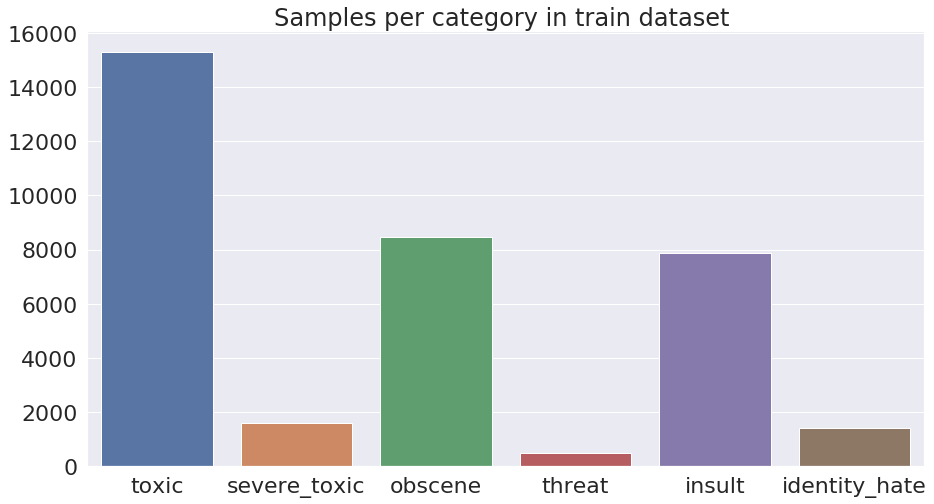

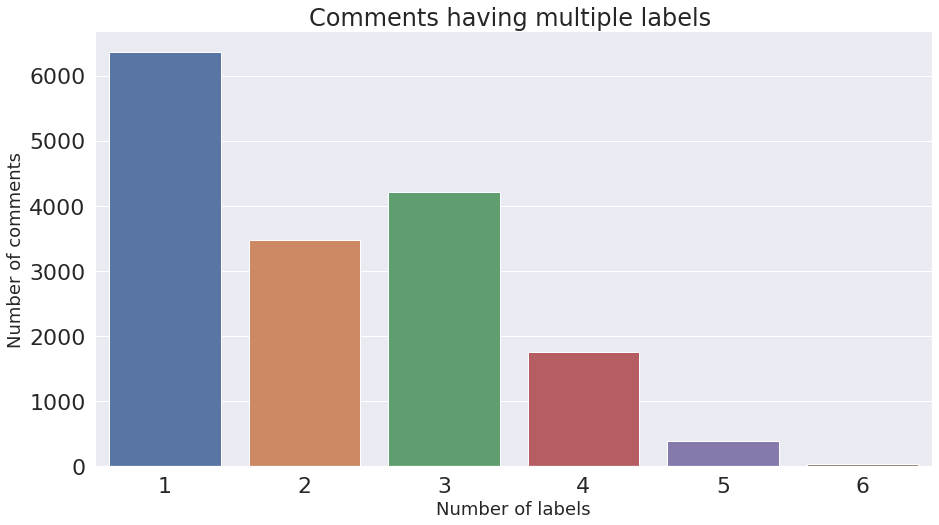

In [ ]:
samples(train, "train")
samples_per_number_of_labels(train)

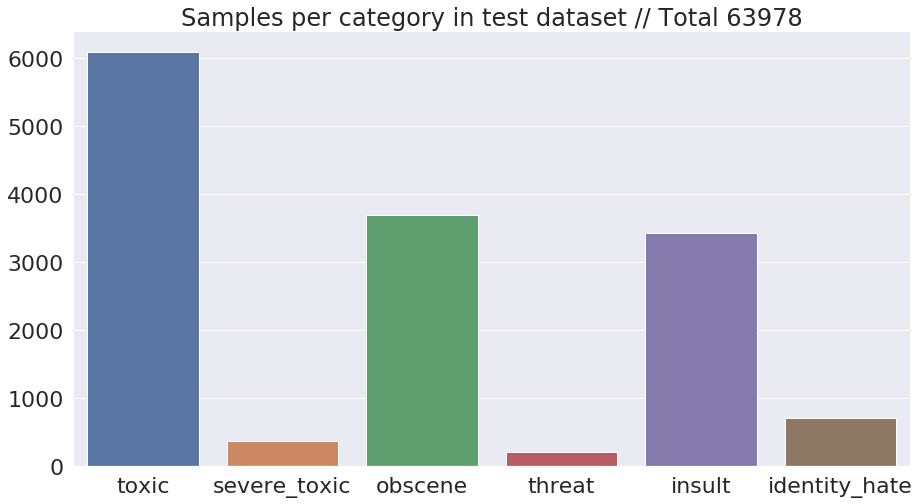

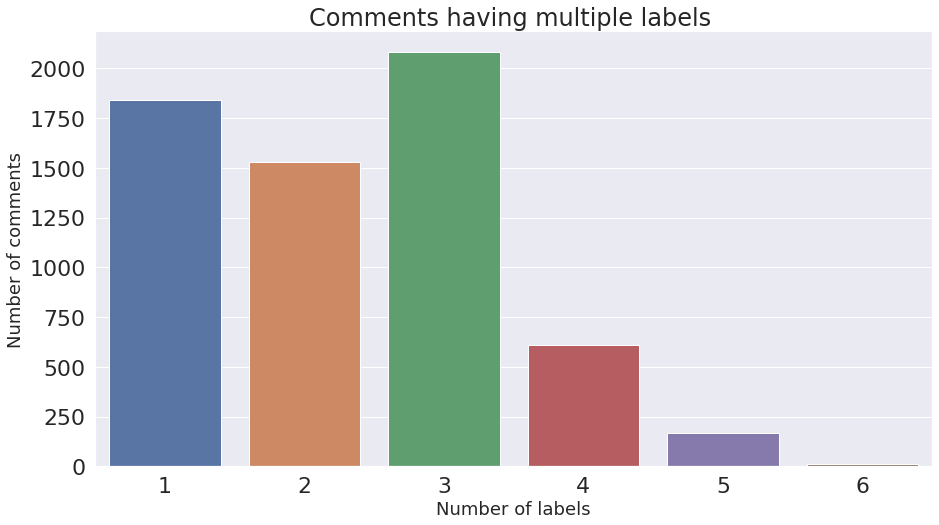

In [ ]:
samples(test, "test")
samples_per_number_of_labels(test)

<center> <h1> Data Preparation



---



In [ ]:
def lemmatize(text):
    sentence = ""
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for word in text.split():
        if word not in stop_words:
            lemma = lemmatizer.lemmatize(word, pos="v")
            sentence += lemma
            sentence += " "
    sentence = sentence.strip()
    return sentence


def normalize(text):
    sentence = text.lower()
    sentence = " ".join(
        re.split("\s+", sentence, flags=re.UNICODE)
    )  # Remove whitespaces
    sentence = re.sub(r"[^\w\s]", "", sentence)  # Remove punctuation
    sentence = re.sub(r"\d+", "", sentence)  # Remove number
    return sentence


def preprocess(text):
    sentence = normalize(text)
    sentence = lemmatize(sentence)
    return sentence

columns = [
    "comment_text",
    "text_lemmatized",
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate",
]


In [ ]:
train["text_lemmatized"] = train.comment_text.apply(preprocess)
train = train[columns]
train.sample(3)

,comment_text,text_lemmatized,toxic,severe_toxic,obscene,threat,insult,identity_hate
156483,To be completely honest that looks 10x as worse and just makes it 10x as confusing.,completely honest look x worse make x confuse,0,0,0,0,0,0
128803,"""\n Hello, Skateroad, and Welcome to Wikipedia! Thank you for your contributions to this free encyclopedia. If you decide that you need help, check out Getting Help below, ask me on my talk page, or place on your talk page and ask your question there. Please remember to sign your name on talk pages by using four tildes (~~~~) or by clicking if shown; this will automatically produce your username and the date. Also, please do your best to always fill in the edit summary field with your edits. Below are some useful links to facilitate your involvement. Happy editing! \n|}""",hello skateroad welcome wikipedia thank contributions free encyclopedia decide need help check get help ask talk page place talk page ask question please remember sign name talk page use tildes click show automatically produce username date please best always fill edit summary field edit useful link facilitate involvement happy edit,0,0,0,0,0,0
65219,"Yup, it is no longer there. A mixup, happens to the best. Cheers 84.90.219.128",yup longer mixup happen best cheer,0,0,0,0,0,0


In [ ]:
test["text_lemmatized"] = test.comment_text.apply(preprocess)
test = test[columns]
test.sample(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,comment_text,text_lemmatized,toxic,severe_toxic,obscene,threat,insult,identity_hate
11330,""" \n\n ==WP Conventions== \n Hello and thanks for the welcome message! Also, a quick question. I'm doing a little housecleaning and am too new to know your/the community's preferences. If I see a name to clarify, I don't know if it is best to create a redirect or to use a piped link. Example: for Eurlyne/Arlene Howell, I think I actually did both. Now I have noticed that Erica Marie Commeau (Miss Maine USA 2005) has a page without her middle name, but don't know if it is better to pipe or create a redirect. I would appreciate some direction. Thanks!!! \n ::Hi Brian... when it comes to full names (as in the example above) its probably best just to get rid of the middle name (this can get tricky in pageantry where names are often used in full where they are not used in full in common usage). As for Erica Commeau... that was probably my fault! What you did with Eurlyne/Arlene Howell was perfect just what I would have done had I picked up on it. There's no hard and fast rule but I'd say that if you can prevent a redirect by piping... go for it (or simply by chopping out the middle name as suggested). \n ::Finally, one other thing, don't forget to sign off with four tildes (~~~~) when you reply on talk pages so your name and the date are stamped ) PagantUpdater """,wp conventions hello thank welcome message quick question little houseclean new know yourthe communitys preferences see name clarify dont know best create redirect use pip link example eurlynearlene howell think actually notice erica marie commeau miss maine usa page without middle name dont know better pipe create redirect would appreciate direction thank hi brian come full name example probably best get rid middle name get tricky pageantry name often use full use full common usage erica commeau probably fault eurlynearlene howell perfect would do pick theres hard fast rule id say prevent redirect pip go simply chop middle name suggest finally thing dont forget sign tildes reply talk page name date stamp pagantupdater,0,0,0,0,0,0
101107,""" \n ::::::""""I am sure that a more reliable source can be found to summarize the organization's position on the ideological spectrum."""" He was ambiguous, and he didn't want to get involved specifically because of you. Why do you steadfastly refuse to accept that? """,sure reliable source find summarize organizations position ideological spectrum ambiguous didnt want get involve specifically steadfastly refuse accept,0,0,0,0,0,0
106194,""" \n\n : Yes, Garlaschelli's reproduction does not reproduce the unrealistic inches-deep shallowness of the Shroud's image which you call a """"floating between the sheets effect"""", perhaps because he used a actual human body with the thickness of a human body, not a flat bas-relief. . ~ """,yes garlaschellis reproduction reproduce unrealistic inchesdeep shallowness shroud image call float sheet effect perhaps use actual human body thickness human body flat basrelief,0,0,0,0,0,0


<center> <h3> Esto es parte del EDA, pero es necesario hacerlo después del preproceso de los datos

--- 

In [ ]:
def most_used(category, samples, data):
    from collections import Counter

    subset = data[data[category] == 1]
    all_values = str(subset.text_lemmatized.values)

    split_it = all_values.split()

    Counter = Counter(split_it)

    most_occur = Counter.most_common(samples)
    most_occur.sort(reverse=True, key=lambda obj: obj[1])

    print(f"{category} : {most_occur}")

In [ ]:
print ("\n THE MOST USED WORDS IN THE TRAIN DATASET ARE:\n\n")

for label in classes:
    most_used(label, 12, train)


 THE MOST USED WORDS IN THE TRAIN DATASET ARE:


toxic : [('delete', 6), ('dont', 5), ('stop', 5), ('edit', 4), ('bullshit', 3), ('ever', 3), ('ass', 3), ('get', 3), ("'hey", 2), ('wp', 2), ('ask', 2), ('fuck', 2)]
severe_toxic : [('fuck', 5), ('go', 3), ('die', 3), ('jew', 3), ('piss', 2), ("'stupid", 2), ('shit', 2), ('youre', 2), ('dont', 2), ('get', 2), ("['cocksucker", 1), ('around', 1)]
obscene : [('fuck', 23), ('go', 5), ('shit', 5), ('like', 5), ('say', 4), ('edit', 4), ('ass', 3), ('little', 3), ('take', 3), ('bitch', 3), ('ever', 3), ('bullshit', 3)]
threat : [('die', 1142), ('ass', 759), ('kill', 486), ('go', 343), ('fuck', 237), ('block', 181), ('must', 163), ('wales', 157), ('jim', 157), ('supertrll', 146), ('page', 136), ('dont', 136)]
insult : [('delete', 6), ('dont', 5), ('stop', 5), ('ass', 4), ('edit', 4), ('go', 3), ('fuck', 3), ('bullshit', 3), ('ever', 3), ('get', 3), ('white', 2), ('gay', 2)]
identity_hate : [('fuck', 24), ('shit', 6), ('go', 5), ('get', 5), ('sa

In [ ]:
print ("\n THE MOST USED WORDS IN THE TEST DATASET ARE:\n\n")

for label in classes:
    most_used(label, 10, test)


 THE MOST USED WORDS IN THE TEST DATASET ARE:


toxic : [('supposedly', 6), ('make', 5), ('iran', 5), ('miles', 4), ('right', 3), ('use', 3), ('say', 3), ('incident', 3), ('article', 3), ('europe', 2)]
severe_toxic : [('fuck', 2198), ('bitch', 943), ('nigger', 752), ('die', 605), ('suck', 553), ('shit', 550), ('ass', 497), ('like', 427), ('niggerjew', 423), ('must', 407)]
obscene : [('supposedly', 6), ('iran', 5), ('miles', 4), ('make', 4), ('like', 3), ('right', 3), ('use', 3), ('say', 3), ('incident', 3), ('article', 3)]
threat : [('must', 323), ('traitor', 313), ('vandal', 313), ('diefuk', 310), ('kill', 285), ('fuck', 167), ('go', 155), ('nigggers', 122), ('ill', 96), ('die', 92)]
insult : [("['dj", 1), ('robinson', 1), ('gay', 1), ('hell', 1), ('suck', 1), ('dick', 1), ("much'", 1), ("'fuck", 1), ('antisemitic', 1), ("cunt'", 1)]
identity_hate : [('nigger', 2213), ('fuck', 1294), ('gay', 1067), ('niggers', 1042), ('faggot', 599), ('fag', 436), ('niggerjew', 423), ('bitch', 421), 

<center> <h1>  Word Embeddings 

---

In [ ]:
embed_size = 100  # how big is each word vector
max_features = 20000  # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100  # max number of words in a comment to use

list_sentences_train = train["text_lemmatized"].fillna("_na_").values
list_sentences_test = test["text_lemmatized"].fillna("_na_").values

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)


In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype="float32")


embeddings_index = dict(
    get_coefs(*o.strip().split()) for o in open("glove.6B.100d.txt")
)

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


<center> <h1> TRAINING MODELS


---

In [ ]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(history.history["acc"])
    ax1.plot(history.history["val_acc"])
    ax1.set(xlabel="epoch", ylabel="accuracy")
    ax1.set_title("model accuracy")
    ax1.legend(["train", "test"], loc="upper left")
    # ax1.show()

    ax2.plot(history.history["loss"])
    ax2.plot(history.history["val_loss"])

    ax2.set_title("model loss")
    ax2.set(xlabel="epoch", ylabel="loss")
    ax2.legend(["train", "test"], loc="upper left")
    plt.tight_layout()
    # ax2.show()

In [ ]:
def load(name):
  model = load_model(f"/content/gdrive/My Drive/Colab Notebooks/{name}.h5")
  return model

In [ ]:
trainable = False
epochs = 100
batch_size = 64
loss = "categorical_crossentropy"

<center> <h2> Neural Networks

---

In [ ]:
%%capture

nn = Sequential()
embedding_layer = Embedding(
    max_features,
    embed_size,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=trainable,
)
nn.add(embedding_layer)
nn.add(Flatten())
nn.add(Dense(6, activation="sigmoid"))
nn.compile(optimizer="adam", loss=loss, metrics=["accuracy"])


In [ ]:
history_nn = nn.fit(
    X_train,
    train[classes].values,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.15,
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 135635 samples, validate on 23936 samples
Epoch 1/100
135635/135635 [==============================] - 11s 78us/step - loss: 0.3527 - acc: 0.4078 - val_loss: 0.3373 - val_acc: 0.4139
Epoch 2/100
135635/135635 [==============================] - 10s 73us/step - loss: 0.3387 - acc: 0.6479 - val_loss: 0.3740 - val_acc: 0.6433
Epoch 3/100
135635/135635 [==============================] - 10s 73us/step - loss: 0.3347 - acc: 0.6998 - val_loss: 0.3261 - val_acc: 0.8359
Epoch 4/100
135635/135635 [==============================] - 10s 75us/step - loss: 0.3173 - acc: 0.8103 - val_loss: 0.3521 - val_acc: 0.6932
Epoch 5/100
135635/135635 [==============================] - 10s 74us/step - loss: 0.3144 - acc: 0.7527 - val_loss: 0.3217 - val_acc: 0.7886
Epoch 6/100
135635/135635 [==============================] - 10s 75us/step - loss: 0.3063 - acc: 0.8300 - val_loss: 0.3238 - val_acc: 0.8490
Epoch 7

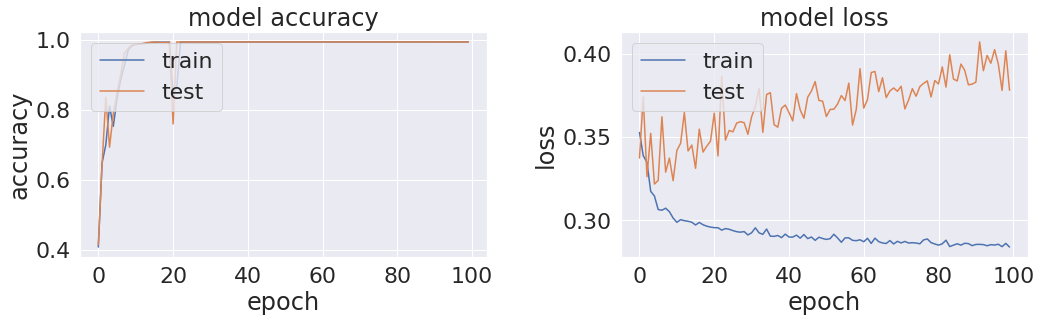

In [ ]:
plot_metrics(history_nn)

In [ ]:
score = nn.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

63978/63978 [==============================] - 3s 42us/step
Test Score: 0.3725221407974704
Test Accuracy: 0.997514770702429


In [ ]:
nn.save(f"/content/gdrive/My Drive/Colab Notebooks/nn_{score[1].round(3)}.h5")


<center> <h2> Convolutional Neural Network

---


In [ ]:
cnn = Sequential()

embedding_layer = Embedding(
    max_features,
    embed_size,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=trainable,
)

cnn.add(embedding_layer)

cnn.add(Conv1D(128, 5, activation="relu"))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(6, activation="sigmoid"))
cnn.compile(optimizer="adam", loss=loss, metrics=["acc"])


In [ ]:
history_cnn = cnn.fit(
    X_train,
    train[classes].values,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.15,
)


Train on 135635 samples, validate on 23936 samples
Epoch 1/10
135635/135635 [==============================] - 104s 764us/step - loss: 0.2852 - acc: 0.9926 - val_loss: 0.2763 - val_acc: 0.9943
Epoch 2/10
135635/135635 [==============================] - 102s 754us/step - loss: 0.2714 - acc: 0.9941 - val_loss: 0.2791 - val_acc: 0.9943
Epoch 3/10
135635/135635 [==============================] - 103s 759us/step - loss: 0.2622 - acc: 0.9941 - val_loss: 0.2815 - val_acc: 0.9944
Epoch 4/10
135635/135635 [==============================] - 102s 755us/step - loss: 0.2539 - acc: 0.9941 - val_loss: 0.2855 - val_acc: 0.9944
Epoch 5/10
135635/135635 [==============================] - 103s 757us/step - loss: 0.2466 - acc: 0.9938 - val_loss: 0.2839 - val_acc: 0.9944
Epoch 6/10
135635/135635 [==============================] - 104s 765us/step - loss: 0.2411 - acc: 0.9934 - val_loss: 0.2885 - val_acc: 0.9901
Epoch 7/10
135635/135635 [==============================] - 103s 761us/step - loss: 0.2364 - acc:

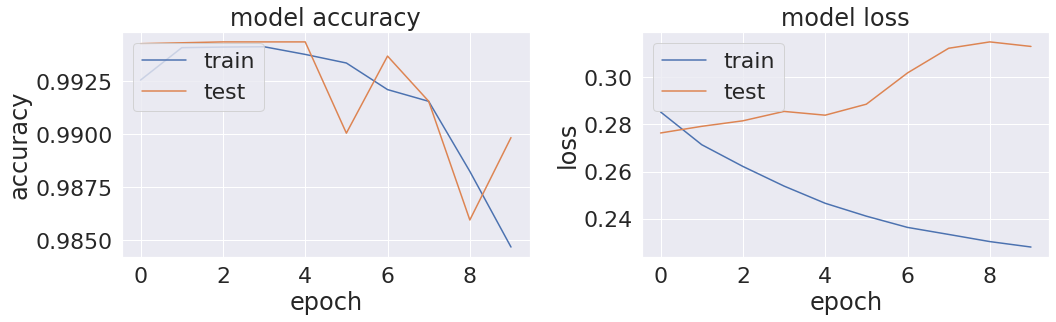

In [ ]:
plot_metrics(history_cnn)

In [ ]:
score = cnn.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


63978/63978 [==============================] - 19s 299us/step
Test Score: 0.32743053419346724
Test Accuracy: 0.9911063177967426


In [ ]:
cnn.save(f"/content/gdrive/My Drive/Colab Notebooks/cnn_{score[1].round(3)}.h5")

<center> <h2> Recurrent Neural Network (LSTM)

In [ ]:
rnn = Sequential()
embedding_layer = Embedding(
    max_features,
    embed_size,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=trainable,
)
rnn.add(embedding_layer)
rnn.add(LSTM(128))

rnn.add(Dense(6, activation="sigmoid"))
rnn.compile(optimizer="adam", loss=loss, metrics=["acc"])

In [ ]:
history_rnn = rnn.fit(
    X_train,
    train[classes].values,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.15,
)

Train on 135635 samples, validate on 23936 samples
Epoch 1/10
135635/135635 [==============================] - 410s 3ms/step - loss: 0.2857 - acc: 0.9880 - val_loss: 0.2745 - val_acc: 0.9916
Epoch 2/10
135635/135635 [==============================] - 405s 3ms/step - loss: 0.2748 - acc: 0.9890 - val_loss: 0.2726 - val_acc: 0.9926
Epoch 3/10
135635/135635 [==============================] - 407s 3ms/step - loss: 0.2701 - acc: 0.9901 - val_loss: 0.2706 - val_acc: 0.9887
Epoch 4/10
135635/135635 [==============================] - 402s 3ms/step - loss: 0.2664 - acc: 0.9900 - val_loss: 0.2702 - val_acc: 0.9926
Epoch 5/10
135635/135635 [==============================] - 402s 3ms/step - loss: 0.2629 - acc: 0.9901 - val_loss: 0.2696 - val_acc: 0.9885
Epoch 6/10
135635/135635 [==============================] - 400s 3ms/step - loss: 0.2584 - acc: 0.9880 - val_loss: 0.2729 - val_acc: 0.9896
Epoch 7/10
135635/135635 [==============================] - 403s 3ms/step - loss: 0.2534 - acc: 0.9810 - val_

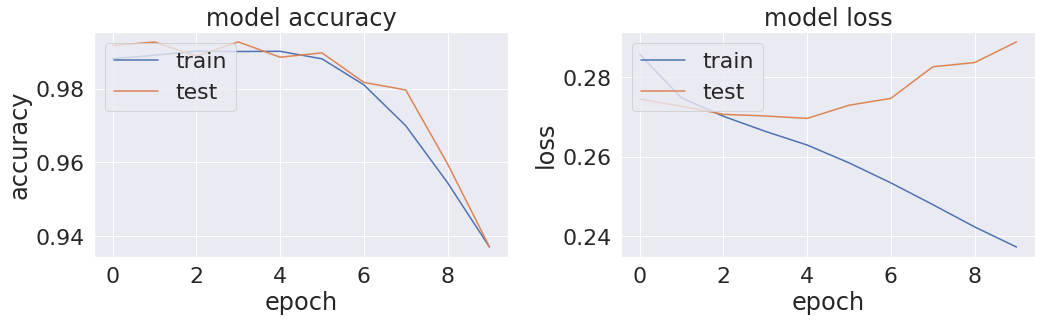

In [ ]:
plot_metrics(history_rnn)

In [ ]:
score = rnn.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

63978/63978 [==============================] - 59s 915us/step
Test Score: 0.30382181292588656
Test Accuracy: 0.9253180780856166


In [ ]:
rnn.save(f"/content/gdrive/My Drive/Colab Notebooks/rnn.h5_{score[1].round(3)}")

<center> <h2> Recurrent Neural Network BLSTM

In [ ]:
blstm = Sequential()
blstm.add(
    Embedding(
        max_features,
        embed_size,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=trainable,
    )
)
blstm.add(Bidirectional(LSTM(64)))
blstm.add(Dropout(0.5))
blstm.add(Dense(6, activation="sigmoid"))
blstm.compile(loss=loss, optimizer="adam", metrics=["accuracy"])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:

history_blstm = blstm.fit(
    X_train,
    train[classes].values,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.15,
)


Train on 135635 samples, validate on 23936 samples
Epoch 1/10
135635/135635 [==============================] - 437s 3ms/step - loss: 0.2908 - acc: 0.9901 - val_loss: 0.2795 - val_acc: 0.9942
Epoch 2/10
135635/135635 [==============================] - 432s 3ms/step - loss: 0.2804 - acc: 0.9924 - val_loss: 0.2735 - val_acc: 0.9943
Epoch 3/10
135635/135635 [==============================] - 431s 3ms/step - loss: 0.2764 - acc: 0.9932 - val_loss: 0.2712 - val_acc: 0.9943
Epoch 4/10
 47936/135635 [=========>....................] - ETA: 4:38 - loss: 0.2736 - acc: 0.9941

In [ ]:

plot_metrics(history_blstm)

In [ ]:

score = blstm.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


In [ ]:

blstm.save(f"/content/gdrive/My Drive/Colab Notebooks/blstm_{score[1].round(3)}.h5")

<center> <h1> Experiment 1

In [ ]:
model = Sequential()
model.add(
    Embedding(
        max_features,
        embed_size,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=trainable,
    )
)
model.add(Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64))
model.add(Dense(6, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history_model = model.fit(
    X_train,
    train[classes].values,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.15,
)



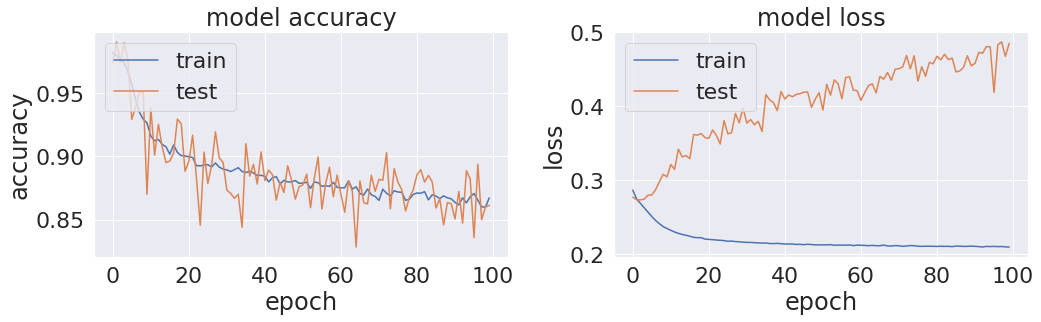

In [ ]:
plot_metrics(history_model)

In [ ]:

score = model.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


63978/63978 [==============================] - 19s 291us/step
Test Score: 0.4865804950457349
Test Accuracy: 0.8478070586782833


In [ ]:

model.save(f"/content/gdrive/My Drive/Colab Notebooks/model_{score[1].round(3)}.h5")

<center> <h2> Experiment 2

In [ ]:
model2 = Sequential()
model2.add(
    Embedding(
        max_features,
        embed_size,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=trainable,
    )
)
model2.add(Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"))
model2.add(MaxPooling1D(pool_size=4))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dense(6, activation="softmax"))
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
history_model2 = model2.fit(
    X_train,
    train[classes].values,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.15,
)


Train on 135635 samples, validate on 23936 samples
Epoch 1/100
 56640/135635 [===========>..................] - ETA: 1:40 - loss: 0.2887 - acc: 0.9815

In [ ]:

plot_metrics(history_model2)

In [ ]:

score = model2.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


In [ ]:

model2.save(f"/content/gdrive/My Drive/Colab Notebooks/model2_{score[1].round(3)}.h5")


In [ ]:
last = Sequential()
last.add(Embedding(max_features, embed_size, 
                               mask_zero=False, weights=[embedding_matrix], trainable=False))
last.add(SpatialDropout1D(0.4))
last.add(LSTM(units=50,  recurrent_dropout=0.2, return_sequences = True))
last.add(Dropout(0.2))
last.add((LSTM(units=50,  recurrent_dropout=0.2, return_sequences = True)))
last.add(Dropout(0.2))
last.add((LSTM(units=50,  recurrent_dropout=0.2)))
last.add(Dense(units=6, activation="softmax"))

last.compile(optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"])


history_last = last.fit(
    X_train,
    train[classes].values,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.15,
)


In [ ]:

plot_metrics(history_last)


In [ ]:


score = last.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])



In [ ]:

last.save(f"/content/gdrive/My Drive/Colab Notebooks/last_{score[1].round(3)}.h5")

<center> <h1> Evaluate Models

---


In [ ]:
def evaluate_model(model):
  instance = """
            wat the fuck that was a legit question..ur being a doush
                """
  instance = preprocess(instance)
  instance = tokenizer.texts_to_sequences(instance)

  flat_list = []
  for sublist in instance:
      for item in sublist:
          flat_list.append(item)

  flat_list = [flat_list]

  np.set_printoptions(formatter={"float_kind": "{:f}".format})

  instance = pad_sequences(flat_list, maxlen=maxlen)
  print("\n#####INSULT####\n")
  print(model.predict(instance))
  print(np.vectorize(lambda x : 1 if x >= 0.5 else 0)(model.predict(instance)))

  instance = """
            !Minnesota is a state.
             """
  instance = preprocess(instance)
  instance = tokenizer.texts_to_sequences(instance)

  flat_list = []
  for sublist in instance:
      for item in sublist:
          flat_list.append(item)

  flat_list = [flat_list]

  instance = pad_sequences(flat_list, maxlen=maxlen)

  print("\n#####NORMAL COMMENT####\n")
  print(model.predict(instance))
  #print(type(model.predict(instance)))
  print(np.vectorize(lambda x : 1 if x >= 0.5 else 0)(model.predict(instance)))
  #print(list(map(lambda x : 1 if x >= 0.5 else 0, list(model.predict(instance) ))))


In [ ]:
#nn = load("nn")
evaluate_model(nn)



#####INSULT####

[[1.000000 0.849469 1.000000 0.000000 1.000000 0.995742]]
[[1 1 1 0 1 1]]

#####NORMAL COMMENT####

[[1.000000 0.999641 1.000000 0.000000 1.000000 0.999977]]
[[1 1 1 0 1 1]]


In [ ]:
#cnn = load("cnn_0.963")
evaluate_model(cnn)

In [ ]:
#rnn = load("rnn")
evaluate_model(rnn)

In [ ]:
#blstm = load("blstm_0.969")
evaluate_model(blstm)

In [ ]:
#model = load("model_0.994")
evaluate_model(model)


#####INSULT####

[[0.241764 0.228369 0.261488 0.000000 0.257051 0.011329]]
[[0 0 0 0 0 0]]

#####NORMAL COMMENT####

[[0.247940 0.248020 0.265873 0.000000 0.238111 0.000055]]
[[0 0 0 0 0 0]]


In [ ]:
model2 = load("model3_0.994")
evaluate_model(model2)

In [ ]:
last = load("last_0.998")
evaluate_model(last)

<center> <h1> Bibliografía



*   [1] Aditya Gaydhani; Vikrant Doma; Shrikant Kendre; Laxmi Bhagwat. *Detecting Hate Speech and Offensive Language on Twitter using Machine  Learning: An N-gram and TFIDF based Approach.* https://arxiv.org/pdf/1809.08651.pdf

* [2] Shanita Biere. *Hate Speech Detection Using Natural
Language Processing Techniques.* https://www.math.vu.nl/~sbhulai/papers/paper-biere.pdf

* [3] Steven Zimmerman; Chris Fox; Udo Kruschwitz. *Improving Hate Speech Detection with Deep Learning Ensembles.* https://www.aclweb.org/anthology/L18-1404.pdf

* [4] Kevin Khieu; Neha Narwal. *Detecting and Classifying Toxic Comments.* https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/reports/6837517.pdf

* [5] Julian Risch; Ralf Krestel. *Toxic Comment Detection in Online Discussions.* https://hpi.de/fileadmin/user_upload/fachgebiete/naumann/publications/2019/risch2019toxic.pdf

* [6] Spiros V. Georgakopoulos; Sotiris K. Tasoulis; Aristidis G. Vrahatis; Vassilis P. Plagianakos. *Convolutional Neural Networks for Toxic Comment Classification.* https://arxiv.org/pdf/1802.09957.pdf

* [7] Marian-Andrei Rizoiu; Tianyu Wang; Gabriela Ferraro; Hanna Suominen. *Transfer Learning for Hate Speech Detection in Social Media.* https://arxiv.org/pdf/1906.03829.pdf

* [8] Usman Malik. *Word Embeddings for Deep Learning in Keras.* https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras/

* [9] Usman Malik. *Movie Sentiment Analysis using Deep Learning in Keras.* https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/



In [ ]:
unlabeled.sample(5)

,comment_text
18200,wat the fuck that was a legit question..ur being a doush
97336,""" \n ::Actually it appears that one women's seat is missing, so they only have 166. """
104629,"== HAHAHA, YOU THINK EXPRESSING CONDOLENCES FOR THE DEAR LEADER GROSSLY OFFENSIVE?! == \n\n \n YOU ARE SUCH A MORON!"
145218,"== Whalocaust returns to Japan. == \n\n The japanese high-seas fleet has decided to resume large scale whaling for the 2016 season, the corresponding article in now on the BBC News website: \n http://www.bbc.com/news/world-asia-34952538"
121721,"It definitely includes [[poi (food), haupia and kalua and I assume a poke and..."
